In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# Generate the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = pd.read_csv("/content/drive/My Drive/data/X_sparse.csv",index_col=False)
y = pd.read_csv("/content/drive/My Drive/data/y_sparse.csv")
X.reset_index(drop=True, inplace=True)
#X.drop(labels = "compound possible",axis=1,inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=22, shuffle=True)

In [ ]:
X_train = pd.DataFrame(normalize(X_train))
X_test = pd.DataFrame(normalize(X_test))

In [ ]:
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,225,226,227,228,229,230,231,232,233,234
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.051516,0.059748,0.008232,0.057004,0.003659,0.059748
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.027412,0.096371,0.068959,0.079131,0.025860,0.096371
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.714325e-08,6.535744e-08,3.267872e-08,8.714325e-08,0.054514,0.060977,0.006463,0.059361,0.002424,0.060977
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.097652,0.132359,0.034707,0.109221,0.015426,0.097652
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.960677e-04,4.901693e-05,7.352540e-05,0.000000e+00,0.054665,0.074094,0.019429,0.059522,0.007286,0.054665


# Set up the Model

In [ ]:
num_feats=X_train.shape[1]
param_grid = {
    
    'learning_rate': [0.0005]
    
}

EPOCHS = 400

In [ ]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train.values), 
                       torch.FloatTensor(y_train.values))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test.values), 
                       torch.FloatTensor(y_test.values))

In [ ]:
def Train_loader(train_data,batch_size):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    return train_loader

def Test_loader(test_data,batch_size):
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size,shuffle=True)
    return test_loader

In [ ]:
batch_size = 128
train_loader = Train_loader(train_data,batch_size)
test_loader = Test_loader(test_data,batch_size)

In [ ]:
class FCN(nn.Module):
    def __init__(self, n_in,n_hidden):
        super(FCN, self).__init__()
        self.layer1 = nn.Linear(n_in, n_hidden)
        self.drop = nn.Dropout(p=0.2)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, n_hidden//2)
        self.layer4 = nn.Linear(n_hidden//2, n_hidden//4)
        self.layer5 = nn.Linear(n_hidden//4, 1)
        '''self.layer6 = nn.Linear(n_hidden//4, n_hidden//2)
        self.layer7 = nn.Linear(n_hidden//2, n_hidden)
        self.layer8 = nn.Linear(n_hidden,1)'''
    
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.drop(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.drop(x)
        #x = self.drop(x)
        x = self.layer3(x)
        x = torch.relu(x)
        x = self.drop(x)
        x = self.layer4(x)
        x = torch.relu(x)
        x = self.drop(x)
        x = self.layer5(x)
        '''x = torch.relu(x)
        x = self.layer6(x)
        x = torch.relu(x)
        x = self.layer7(x)
        x = torch.relu(x)
        x = self.layer8(x)'''

        return x

# Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
n_in = X.shape[1]
n_hidden = 128
criterion = nn.L1Loss()
model = FCN(n_in,n_hidden)
model.to(device)

FCN(
  (layer1): Linear(in_features=235, out_features=128, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (layer5): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
all_train_loss = []
all_val_loss = []
for learning_rate in param_grid['learning_rate']:

    optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_epoch=[]
    val_loss_epoch=[]
    model.train()
    
    print("learning rate:{}".format(learning_rate))
    for e in range(1, EPOCHS+1):
        epoch_loss = 0
        for X_tra, y_tra in train_loader:
            X_tra, y_tra = X_tra.to(device), y_tra.to(device)
            optimizer.zero_grad()
            y_pred = model(X_tra)
            #print(y_batch[0],y_pred[0])   
            loss = criterion(y_pred, y_tra)
            #print(loss)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            

        # Validation 
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_test_pred = model(X_batch)
                loss = criterion(y_test_pred, y_batch)
                val_loss += loss.item()
                  
        #print(len(train_loader))
        print(f'Epoch {e+0:03}: | Train_Loss: {epoch_loss/len(train_loader):.5f} | Test_Loss: {val_loss/len(test_loader):.5f}')
        train_loss_epoch.append(epoch_loss/len(train_loader))
        val_loss_epoch.append(val_loss/len(test_loader))
    all_train_loss.append(train_loss_epoch)
    all_val_loss.append(val_loss_epoch)
    torch.save(model, 'model(lr{},batch{}).pth'.format(learning_rate,batch_size))


learning rate:0.0005
Epoch 001: | Train_Loss: 0.54652 | Test_Loss: 0.49380
Epoch 002: | Train_Loss: 0.48309 | Test_Loss: 0.44824
Epoch 003: | Train_Loss: 0.43770 | Test_Loss: 0.42083
Epoch 004: | Train_Loss: 0.39486 | Test_Loss: 0.36928
Epoch 005: | Train_Loss: 0.35153 | Test_Loss: 0.32439
Epoch 006: | Train_Loss: 0.32527 | Test_Loss: 0.30323
Epoch 007: | Train_Loss: 0.31190 | Test_Loss: 0.29887
Epoch 008: | Train_Loss: 0.30219 | Test_Loss: 0.29331
Epoch 009: | Train_Loss: 0.29401 | Test_Loss: 0.27711
Epoch 010: | Train_Loss: 0.28709 | Test_Loss: 0.27838
Epoch 011: | Train_Loss: 0.28453 | Test_Loss: 0.26715
Epoch 012: | Train_Loss: 0.28156 | Test_Loss: 0.27438
Epoch 013: | Train_Loss: 0.27342 | Test_Loss: 0.26627
Epoch 014: | Train_Loss: 0.26891 | Test_Loss: 0.25726
Epoch 015: | Train_Loss: 0.26538 | Test_Loss: 0.25387
Epoch 016: | Train_Loss: 0.25923 | Test_Loss: 0.24712
Epoch 017: | Train_Loss: 0.25713 | Test_Loss: 0.24323
Epoch 018: | Train_Loss: 0.25772 | Test_Loss: 0.24699
Epoch 0

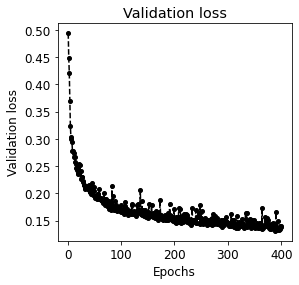

In [ ]:
for learning_rate in param_grid['learning_rate']: 
    epoch_val = range(1,len(val_loss_epoch) + 1)
    fig = plt.figure()
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])


    plt.plot(epoch_val, val_loss_epoch, 'o--k', markersize = 4)
    plt.rc('font', size = 12)
    plt.xlabel('Epochs')
    plt.ylabel('Validation loss') 
    plt.title("Validation loss")

Text(0.5, 1.0, 'Training loss')

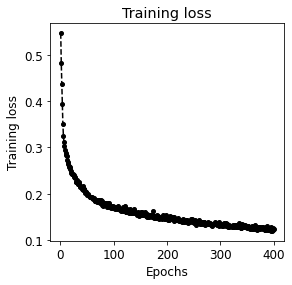

In [ ]:

epoch_val = range(1,len(train_loss_epoch) + 1)
fig = plt.figure()
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])


plt.plot(epoch_val, train_loss_epoch, 'o--k', markersize = 4)
plt.rc('font', size = 12)
plt.xlabel('Epochs')
plt.ylabel('Training loss') 
plt.title("Training loss")

In [ ]:
y_test_predict = model(torch.FloatTensor(X_test.values).to(device))

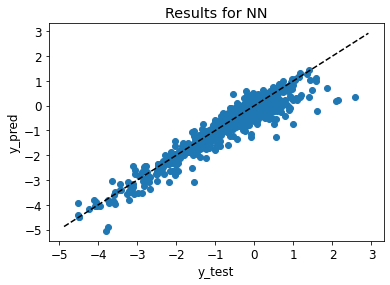

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.scatter(y_test, (y_test_predict.cpu().detach().numpy()).flatten())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
ax.set_xlabel("y_test")
ax.set_ylabel("y_pred")
ax.set_title("Results for NN")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test,y_test_predict.cpu().detach().numpy()).flatten())

[0.13931413]
